<a href="https://colab.research.google.com/github/vm00328/vm00328_coursework_com2025/blob/master/Week_3_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3: Introduction to Artificial Neural Networks

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


## Activation functions
Activation functions are mathematical equations that determine the output of a neural network. The function is attached to each neuron in the network, and determines whether it should be activated (“fired”) or not, based on whether each neuron’s input is relevant for the model’s prediction. Activation functions also help normalize the output of each neuron.

An additional aspect of activation functions is that they must be computationally efficient because they are calculated across thousands or even millions of neurons for each data sample. Modern neural networks use a technique called backpropagation to train the model, which places an increased computational strain on the activation function, and its derivative function.

The popular activation functions and their derivatives are represented:

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

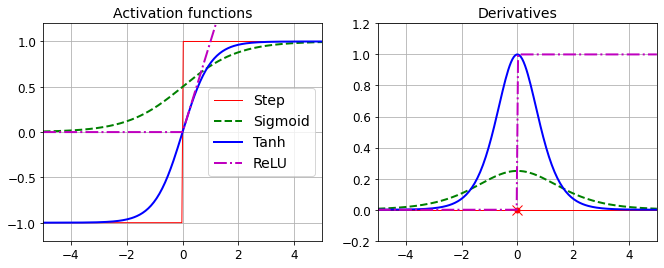

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## NN for MNIST

In this section we will build an MLP with TensorFlow, and we will implement Minibatch Gradient Descent to train it on the MNIST dataset. The first step is the construction phase, building the TensorFlow graph. The second step is the execution phase, where you actually run the graph to train the model.

First we need to import the tensorflow library. Then we must specify the number of inputs and outputs, and set the number of hidden neurons in each layer:

In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
x_valid, x_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
print(x_train.shape)

(55000, 784)


# Building a model with Softmax
Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.

For example, returning to the image analysis we saw in Figure 1, Softmax might produce the following likelihoods of an image belonging to a particular class:

![softmax](https://raw.githubusercontent.com/hqsiswiliam/surrey_ai_lab_dataset/master/SoftmaxLayer.svg)

- reference: [Multi-Class Neural Networks: Softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax)


In [7]:
n_inputs = 28*28  # MNIST
n_hidden1 = 256
n_hidden2 = 128
n_outputs = 10

model = keras.Sequential(
    [
        keras.Input(shape=(28*28,)),
        layers.Dense(n_hidden1, name='hidden1', activation='relu'),
        layers.Dense(n_hidden2, name='hidden2', activation='relu'),
        layers.Dense(n_outputs, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 256)               200960    
_________________________________________________________________
hidden2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Now that we have the neural network model ready to go, we need to define the cost function that we will use to train it. We will use cross entropy, cross entropy will penalize models that estimate a low probability for the target class.

In [8]:
crossentropy = keras.losses.CategoricalCrossentropy()

We have the neural network model, we have the cost function, and now we need to define a GradientDescentOptimizer that will tweak the model parameters to minimize the cost function.

In [9]:
learning_rate = 0.001
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()

And now we can train the model:

In [10]:
model.compile(loss=crossentropy, optimizer=optimizer, metrics=[accuracy])
model.fit(x_train,y_train,batch_size=128,epochs=10,validation_data=(x_valid,y_valid), shuffle=True)

Epoch 1/10
430/430 [==============================] - 5s 3ms/step - loss: 2.2457 - categorical_accuracy: 0.1582 - val_loss: 2.0581 - val_categorical_accuracy: 0.3886
Epoch 2/10
430/430 [==============================] - 1s 3ms/step - loss: 1.9890 - categorical_accuracy: 0.4658 - val_loss: 1.7917 - val_categorical_accuracy: 0.6130
Epoch 3/10
430/430 [==============================] - 1s 3ms/step - loss: 1.7213 - categorical_accuracy: 0.6504 - val_loss: 1.5109 - val_categorical_accuracy: 0.7204
Epoch 4/10
430/430 [==============================] - 1s 3ms/step - loss: 1.4464 - categorical_accuracy: 0.7307 - val_loss: 1.2545 - val_categorical_accuracy: 0.7684
Epoch 5/10
430/430 [==============================] - 1s 3ms/step - loss: 1.2088 - categorical_accuracy: 0.7731 - val_loss: 1.0499 - val_categorical_accuracy: 0.7960
Epoch 6/10
430/430 [==============================] - 1s 3ms/step - loss: 1.0235 - categorical_accuracy: 0.7935 - val_loss: 0.8977 - val_categorical_accuracy: 0.8142
Epoc

Now that the neural network is trained, you can use it to make predictions. To do that, you can reuse the same construction phase, but change the execution phase like this:

In [ ]:
y_pred = model.predict(x_test)
# Since y_pred only output probabilities over classes, we retrieve the one with max probability
y_pred = np.argmax(y_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test_argmax)

Predicted classes: [7 2 1 ... 4 8 6]
Actual classes:    [7 2 1 ... 4 5 6]


## <font color='red'> Task1</font>

**Task 1:** Train your own MLP on the MNIST dataset and see if you can get over 95% precision.

**This can be achieved by many ways, here we just replace SGD optmiser by Adam optimiser.**

# Challenge
# <font color='red'> Task of this Lab </font>
- We a bunch of image data about **Afghan Hounds** and **Bedlington** (Two types of dogs)
  - Labels:
    - 0: an Afghan Hound
    - 1: a Bedlington Terrier
  - can you create a classifier that predict the which image data belongs to which kinds of dog?
  - You need to build a model to classify image into 2 types of dogs
  - after you've built the model, you need to assign a predicted value to `y_pred` based on `x_test`
  - The predicted reults should have a prediction accuracy > 0.7
  - The **greyscale** image data has been processed as 100x100x1 numpy array (for a single image)
  - Note:
    - You can flatten the image into 1-D array, so you can process it with linear classifier
    - You might need to normalize the pixel value of the image to get good performance
    - You can use loss related to binary
    - Different activation functions might have great impact to the result, please think about why

### Example of images
##### Afghan Hound
![Afghan Hound](https://raw.githubusercontent.com/hqsiswiliam/surrey_ai_lab_dataset/master/dogs/dog0_grey.png)
##### Bedlington Terrier
![Bedlington Terrier](https://raw.githubusercontent.com/hqsiswiliam/surrey_ai_lab_dataset/master/dogs/dog1_grey.png)

In [11]:
# We will help you to install necessary components
!rm *.txt *.pyc > /dev/null
!wget http://35.197.245.114:8765/static/requirements.txt
!wget http://35.197.245.114:8765/static/challenge.pyc
!wget http://35.197.245.114:8765/static/ImagePredictionDogs.pyc
!pip install -q -r requirements.txt

rm: cannot remove '*.txt': No such file or directory
rm: cannot remove '*.pyc': No such file or directory
--2021-04-25 16:40:20--  http://35.197.245.114:8765/static/requirements.txt
Connecting to 35.197.245.114:8765... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      81  --.-KB/s    in 0s      

2021-04-25 16:40:20 (16.6 MB/s) - ‘requirements.txt’ saved [81/81]

--2021-04-25 16:40:20--  http://35.197.245.114:8765/static/challenge.pyc
Connecting to 35.197.245.114:8765... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2301 (2.2K) [application/x-python-code]
Saving to: ‘challenge.pyc’

challenge.pyc       100%[===================>]   2.25K  --.-KB/s    in 0s      

2021-04-25 16:40:20 (432 MB/s) - ‘challenge.pyc’ saved [2301/2301]

--2021-04-25 16:40:20--  http://35.197.245.114:8765/static/ImagePredictionDogs.pyc
Connecting to 35.197.245.114:8765... connec

In [12]:
from ImagePredictionDogs import AILabDogsClassification

[==================================================]Downloading cache_data/dogs/dogs_test.h5
[==================================================]

In [13]:
# Please enter your URN to the URN varibale here, it's important!
# Please don't change the number in week and course, or you won't be graded for this lab!

URN = '656905'
week = 3
course_module = 'com2028'

task = AILabDogsClassification(URN, week, course_module)

In [38]:
# We've prepared the data for you, you need to train a model based on the data we provides

x_train, y_train, x_test = task.get_train_data()

# Your code goes here

# Adding necessary imports
import keras
import numpy as np

num_classes = 2
#input_shape = (100, 100, 1) commented out because not used anywhere

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes) not going to use y_test

x_train = x_train.reshape(-1, 100*100)
x_test = x_test.reshape(-1, 100*100)
y_train = y_train.astype(np.int32)
#y_test = y_test.astype(np.int32)     not using y_test

n_inputs = 100*100
n_hidden1 = 256
n_hidden2 = 128
n_outputs = 2       # we need 2 categories

model = keras.Sequential(
    [
        keras.Input(shape=(n_inputs,)),
        layers.Dense(n_hidden1, name='hidden1', activation='relu'),
        layers.Dense(n_hidden2, name='hidden2', activation='relu'),
        layers.Dense(n_outputs, activation="softmax")
    ]
)

model.summary()

#Need to define the cost function
crossentropy = keras.losses.CategoricalCrossentropy()

learning_rate = 0.001
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()
#Now we train the model
model.compile(loss=crossentropy, optimizer=optimizer, metrics=[accuracy])
model.fit(x_train,y_train,batch_size=128,epochs=50, shuffle=True)

x_train shape: (267, 100, 100, 1)
267 train samples
67 test samples
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 256)               2560256   
_________________________________________________________________
hidden2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 258       
Total params: 2,593,410
Trainable params: 2,593,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
3/3 [==============================] - 0s 6ms/step - loss: 0.7364 - categorical_accuracy: 0.4683
Epoch 2/50
3/3 [==============================] - 0s 5ms/step - loss: 0.7053 - categorical_accuracy: 0.5039
Epoch 3/50
3/3 [==============================] - 0s 5ms/step - loss: 0.6987 - categorica

In [39]:
# Then, you will use the trained model to get y_pred, and this will be sent to us

y_pred = model.predict(x_test)
# print(y_pred) used only for demonstration purposes for better personal understanding

#argmax returns the indices of the maximum values along a given axis
y_pred = np.argmax(y_pred, axis=-1)

# Please use the following code to evaluate your result,  this is a necessary option, best regards!
# Accuracy can be increased by increasing the number of epochs.
task.evaluate(y_pred.flatten().tolist(), model)

The accuracy of your result is: 0.8208955223880597
Thank you URN: 656905, we've received your result!
